In [ ]:
import os
import requests
import random
import math
import shutil
import cv2
import torch
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from glob import glob
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

#Aquisição do dataset (Face Mask Detection)
https://www.kaggle.com/andrewmvd/face-mask-detection

Slides : https://www.canva.com/design/DAE12FTLu3c/ctnRrVzSXWCc6ryhinHaLQ/view?utm_content=DAE12FTLu3c&utm_campaign=designshare&utm_medium=link&utm_source=publishsharelink


In [ ]:
os.environ['KAGGLE_USERNAME'] = "geraldobraz"
os.environ['KAGGLE_KEY'] = "fbca5960f1451ba427d6a9397840aa67"
!kaggle datasets download -d andrewmvd/face-mask-detection
!unzip -q face-mask-detection.zip

100% 397M/398M [00:03<00:00, 110MB/s] 
100% 398M/398M [00:03<00:00, 133MB/s]


In [ ]:
caminhos_box_labels = sorted(glob(os.path.join('annotations','*')))
caminho_imagens = sorted(glob(os.path.join('images','*')))
print('labels = ',caminhos_box_labels[:5])
print('imagens = ',caminho_imagens[:5])

labels =  ['annotations/maksssksksss0.xml', 'annotations/maksssksksss1.xml', 'annotations/maksssksksss10.xml', 'annotations/maksssksksss100.xml', 'annotations/maksssksksss101.xml']
imagens =  ['images/maksssksksss0.png', 'images/maksssksksss1.png', 'images/maksssksksss10.png', 'images/maksssksksss100.png', 'images/maksssksksss101.png']


#Classes

In [ ]:
class Imagem:


  def __init__(self,nome,Imagem_box,num_box):

    self.nome = nome.rsplit('.', 1)[0] #tira a extensao

    self.Imagem_box = Imagem_box
    
    self.num_box = num_box

  def lista_box(self):
    return self.Imagem_box
  
  def nome_arquivo(self):
    return self.nome
  
  def num_box(self):
    return self.num_box
  
  pass

In [ ]:
class Imagem_box:
  '''
    todas as informações de uma imagem 
    Largura, altura
    e a caixa da box(xmin,xmax, ymin,ymax)
  '''
  def __init__(self, classe ,largura, altura, xmin,xmax,ymin,ymax):
    
    self.classe = classe

    self.largura = largura
    self.altura = altura
    
    self.xmin = xmin  
    self.xmax = xmax

    self.ymin = ymin
    self.ymax = ymax


  def info(self):
    print(f'Classe = {self.classe}\n'+
          f'largura = {self.largura}\n'+
          f'altura = {self.altura}\n'+
          f'xmin = {self.xmin}\n'+
          f'xmax = {self.xmax}\n'+
          f'ymin = {self.ymin}\n'+
          f'ymax = {self.ymax}\n')
  
  def box(self):
    return self.largura , self.xmin, self.xmax, self.ymin, self.ymax

  def classe(self):
    return self.classe

  def largura(self):
    return self.largura
  
  def altura(self):
    return self.altura

  def xmin(self):
    return self.xmin
  
  def xmax(self):
    return self.xmax
  
  def ymin(self):
    return self.ymin
  
  def ymax(self):
    return self.ymax

  pass

In [ ]:
class Box:

  '''
  recebe o tamanho e o o x_center e y_center de uma box
  que esta em uma imagem
  '''

  def __init__(self,classe,largura, altura, x_center,y_center):
    self.classe = classe
    self.largura = largura
    self.altura = altura 
    self.x_center = x_center 
    self.y_center = y_center

  def info(self):
    print(f'classe = {self.classe}\n'+
        f'largura = {self.largura}\n'+
        f'altura = {self.altura}\n'+
        f'x_center = {self.x_center}\n'+
        f'y_center = {self.y_center}\n')

  def classe(self):
    return self.classe

  def largura(self):
    return self.largura

  def altura(self):
    return self.altura

  def x_center(self):
    return self.x_center

  def y_center(self):
    return self.y_center

  pass

#Funções

In [ ]:
def listar_imagem_box(lista_caminhos_box_labels):
  '''
  recebe os caminhos das informaçoes de onde estao as box em cada imagem
  depois retorna uma lista com a classe image
  '''    
  lista_imagem = []

  for imagem in lista_caminhos_box_labels:
    tree = ET.parse(imagem)
    root = tree.getroot()

    classes = []

    total_box = 0 
    
    # nome arquivo
    for child in root.iter('filename'):
      nome = child.text

    for child in root.iter('width'):
      largura = int(child.text)

    for child in root.iter('height'):
      altura = int(child.text)

    #classe e box
    for child in root.iter('object'):

      for classe in child.findall('name'):
        if classe.text == 'with_mask':
          classe = 1
        elif classe.text =='without_mask':
          classe = 0
        else:
          classe = 2

      for box in child.findall('bndbox'):

        for xmin in box.findall('xmin'):
          xmin = int(xmin.text)
        for xmax in box.findall('xmax'):
          xmax = int(xmax.text)   

        for ymin in box.findall('ymin'):
          ymin = int(ymin.text)   
        for ymax in box.findall('ymax'):
          ymax = int(ymax.text)

      classes.append(Imagem_box(classe, largura, altura,xmin,xmax,ymin,ymax))
      total_box +=1

    img = Imagem(nome,classes, total_box)

    lista_imagem.append(img)

  return lista_imagem

In [ ]:
def normalizar_imagem(imagem):
  '''
  recebe um tipo Imagem
  normalizar entre 0 e 1
  retorna a lista das boxs daquela imagem
  '''  

  box_normalizado = []

  for index_box in range(imagem.num_box):
    i = imagem.lista_box()[index_box]
    largura = i.largura
    altura = i.altura
    xmin = i.xmin
    xmax = i.xmax
    ymin = i.ymin
    ymax = i.ymax

    # normalizar
    xmin = xmin/largura
    xmax = xmax/largura

    ymin = ymin/altura
    ymax = ymax/altura

    largura_box = xmax - xmin
    altura_box = ymax - ymin

    x_central = (largura_box/2) + xmin
    y_central = (altura_box /2) + ymin

    b = Box(imagem.lista_box()[index_box].classe,largura_box, altura_box,
            x_central,y_central)

    box_normalizado.append(b)

  return box_normalizado
  

In [ ]:
def criar_pastas(tipo):
  TV = ['treino', 'validacao']
  for c in TV:
    os.makedirs(os.path.join("dataset",tipo,c),exist_ok=True)

In [ ]:
def redimenciona_imagens(caminho_imagens,largura):

  for r in tqdm(caminho_imagens):
    img = Image.open( r )

    largura_original , altura_original = img.size
    altura = round(largura *altura_original/largura_original )

    img = img.resize([altura,largura])
    img.save(r)

In [ ]:
def organizar_dataset(imagem, labels):
  '''
  mistura o dataset devolvendo uma lista com as imagens/validacao/teste devidamente
  misturados e organizados com suas labels
  '''
  from sklearn.model_selection import train_test_split
  images_train, images_else, labels_train, labels_else = [],[],[],[] 
  images_val, images_test, labels_val, labels_test = [],[],[],[]

  show_count = 5 # used <5. Compare images>
  images_train, images_else, labels_train, labels_else = train_test_split(imagem,labels, test_size = 0.2)
  images_val, images_test, labels_val, labels_test = train_test_split(images_else,labels_else, test_size = show_count 
                                                                      / len(images_else))
  print('treino: ',len(images_train),'validacao: ', len(images_val), 'teste: ',len(images_test))

  return images_train, labels_train, images_val , labels_val,images_test , labels_test

In [ ]:
def criar_dataset_YOLO(lista_labels_imagem,caminho_imagens,num_splite):
  
  treino_imagem = []
  treino_labels = []

  validacao_imagem = []
  validacao_labels = []

  teste_imagem = []
  teste_validacao = []

  treino_imagem , treino_labels,validacao_imagem ,validacao_labels, teste_imagem,teste_labels = organizar_dataset(caminho_imagens, lista_labels_imagem)

#------------------------------------------------------------------------------#

  if len(glob(os.path.join('images','*'))) != 5: #se la tiver movido nao exercuta
    criar_pastas('images')

    for img in treino_imagem:
      shutil.copy(img,os.path.join("dataset",'images','treino',Path(img).name))

    for img in validacao_imagem:
      shutil.copy(img,os.path.join("dataset",'images','validacao',Path(img).name))

    for img in teste_imagem:
      shutil.copy(img,os.path.join("dataset",'images','treino',Path(img).name))   

#------------------------------------------------------------------------------#

  criar_pastas('labels')

  for img in treino_labels:

    normalizado = normalizar_imagem(img)

    for box in normalizado:

      largura_box = box.largura
      altura_box = box.altura
      x_center = box.x_center
      y_center = box.y_center

      arquivo_imagem = open(os.path.join('dataset','labels','treino',f'{img.nome}.txt'),'a')
      arquivo_imagem.write(f'{box.classe} {x_center} {y_center} '+
                          f'{largura_box} {altura_box}\n')

  for img in teste_labels:

    normalizado = normalizar_imagem(img)

    for box in normalizado:

      largura_box = box.largura
      altura_box = box.altura
      x_center = box.x_center
      y_center = box.y_center

      arquivo_imagem = open(os.path.join('dataset','labels','treino',f'{img.nome}.txt'),'a')
      arquivo_imagem.write(f'{box.classe} {x_center} {y_center} '+
                          f'{largura_box} {altura_box}\n')
  
  for img in validacao_labels:

    normalizado = normalizar_imagem(img)

    for box in normalizado:

      largura_box = box.largura
      altura_box = box.altura
      x_center = box.x_center
      y_center = box.y_center

      arquivo_imagem = open(os.path.join('dataset','labels','validacao',f'{img.nome}.txt'),'a')
      arquivo_imagem.write(f'{box.classe} {x_center} {y_center} '+
                          f'{largura_box} {altura_box}\n') 

  arquivo_imagem.close()

#------------------------------------------------------------------------------#


#Exercuta Funções

In [ ]:
imagem = listar_imagem_box(caminhos_box_labels)

In [ ]:
num_splite = 5
criar_dataset_YOLO(imagem,caminho_imagens,num_splite)

treino:  682 validacao:  166 teste:  5


Teste labels aleatorias

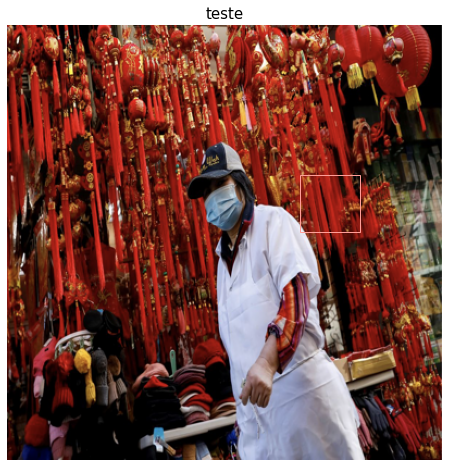

In [ ]:
import matplotlib.image as img
import matplotlib.image as mpimg
import re
import matplotlib

img_random_treino = glob(os.path.join('dataset','images','treino','*'))
img_random = img_random_treino + glob(os.path.join('dataset','images','validacao','*'))

index = random.randint(0,len(img_random))

for imag in img_random:
  if Path(imag).name == imagem[index].nome+'.png':

    imagem_random = imagem[index]
    
    caminho = os.path.join('dataset','images','treino',Path(imag).name)
    if caminho in img_random_treino:
      pass
    else:
      caminho = os.path.join('dataset','images','validacao',Path(imag).name)


i = img.imread(caminho)
ni = np.array(i)
colors = ['#FF3838', '#FF9D97', '#FF701F']

figure = plt.figure(figsize = ( 8,  8))
ax = figure.add_subplot(1, 1, 1)
ax.imshow(mpimg.imread(caminho))

for box in imagem_random.lista_box():
    l, x1, x2, y1, y2 = box.box()
    ax.add_patch(matplotlib.patches.Rectangle((x1, y1), x2 - x1, y2 - y1, color = colors[1], fill = False))
ax.set_title("teste", fontsize = 15)
ax.axis("off")
plt.show()

# plt.imshow(ni)

#YOLO

Criar arquivo ymal


In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

import torch
from yolov5 import utils
display = utils.notebook_init()  # checks
%cd ..

YOLOv5 🚀 v6.0-197-g0cf932b torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 43.2/78.2 GB disk)
/content


In [ ]:
arquivo_yaml = "path: ../dataset  # dataset root dir\ntrain: images/treino  # train images (relative to 'path') ? images\nval: images/validacao  # val images (relative to 'path') ? images\ntest:  # test images (optional) \n\n# number of classes \nnc: 3 \n\n# class names\nnames: ['sem', 'com','incort']\n"

In [ ]:
diretorio_yaml = os.path.join('yolov5','data')
with open(os.path.join(diretorio_yaml,'face_mask_detection.yaml'),'w') as arq:
  arq.write(arquivo_yaml)

In [ ]:
epochs = 10
batch_size = 8 # se bota 16 ele quebra a vram
img_size = 640
otimizador = 'SGD' # Adam  
model_nome = 'yolov5x'

#Testes

Modelo yolov5l(large) com otimizador em SGD 20 epocas



In [ ]:
!python train.py --epochs 20 --batch-size 8 --weights yolov5l.pt \
                --cfg '/content/yolov5/models/yolov5l.yaml'  \
                --data face_mask_detection.yaml --img 640 \
                --optimizer 'SGD'

In [ ]:
!zip -r -q  "Large_SGD_20.zip" "/content/yolov5/runs/train/exp"

Modelo yolov5l(large) otimizador ADAM 20 epocas



In [ ]:
!python train.py --epochs 20 --batch-size 8 --weights yolov5l.pt \
                --cfg '/content/yolov5/models/yolov5l.yaml'  \
                --data face_mask_detection.yaml --img 640 \
                --optimizer 'Adam'

In [ ]:
!zip -r -q  "Large_ADAM_20.zip" "/content/yolov5/runs/train/exp2"

Modelo yolov5l(large) otimizador ADAM 50 epocas

In [ ]:
!python train.py --epochs 50 --batch-size 8 --weights yolov5l.pt \
                --cfg '/content/yolov5/models/yolov5l.yaml'  \
                --data face_mask_detection.yaml --img 640 \
                --optimizer 'Adam'

Modelo yolov5X(Xlarge) otimizador ADAM 20 epocas

In [ ]:
%cd yolov5
!python train.py --epochs 20 --batch-size 8 --weights yolov5x.pt \
                --cfg '/content/yolov5/models/yolov5x.yaml'  \
                --data face_mask_detection.yaml --img 640 \
                --optimizer 'Adam'

/content/yolov5
train: weights=yolov5x.pt, cfg=/content/yolov5/models/yolov5x.yaml, data=face_mask_detection.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=20, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=Adam, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-197-g0cf932b torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.01

In [ ]:
!zip -r -q  "XLarge_ADAM_20.zip" "/content/yolov5/runs/train/exp4"

Modelo yolov5X(Xlarge) otimizador SGD 20 epocas

In [ ]:
!python train.py --epochs 20 --batch-size 8 --weights yolov5x.pt \
                --cfg '/content/yolov5/models/yolov5x.yaml'  \
                --data face_mask_detection.yaml --img 640 \
                --optimizer 'SGD'

Traceback (most recent call last):
  File "train.py", line 26, in <module>
    import torch
  File "/usr/local/lib/python3.7/dist-packages/torch/__init__.py", line 197, in <module>
    from torch._C import *  # noqa: F403
RuntimeError: KeyboardInterrupt: 


In [ ]:
!zip -r -q  "XLarge_SGD_20.zip" "/content/yolov5/runs/train/exp5"

Modelo yolovx(Xlarge) Otimizador SGD 10 epocas

In [ ]:
!python train.py --epochs 10 --batch-size 8 --weights yolov5x.pt \
                --cfg '/content/yolov5/models/yolov5x.yaml'  \
                --data face_mask_detection.yaml --img 640 \
                --optimizer 'SGD'

In [ ]:
!zip -r -q  "XLarge_SGD_10.zip" "/content/yolov5/runs/train/exp6"

In [ ]:
!python train.py --epochs 10 --batch-size 8 --weights yolov5x.pt \
                --cfg '/content/yolov5/models/yolov5x.yaml'  \
                --data face_mask_detection.yaml --img 640 \
                --optimizer 'Adam'

In [ ]:
!zip -r -q  "XLarge_ADAM_10.zip" "/content/yolov5/runs/train/exp7"

In [ ]:
!python detect.py --weights '/content/yolov5/runs/train/exp/weights/best.pt' \
                  --source '/content/images/maksssksksss127.png' \
                  --img-size 640\
                  --conf-thres 0.25 --iou-thres 0.45

#Validação cruzada


In [ ]:
def move_arquivos(lista_arquivos,pasta):
  for img in lista_arquivos:
    shutil.move(img,os.path.join(pasta,Path(img).name))

In [ ]:
#imagens
dataset = sorted(glob(os.path.join('images','*')))

In [ ]:
#labels
pasta_labels_treino = os.path.join('dataset','labels','treino')
pasta_labels_validaco = os.path.join('dataset','labels','validacao')

labels_treino = sorted(glob(os.path.join(pasta_labels_treino,'*')))
labels_validacao = sorted(glob(os.path.join(pasta_labels_validaco,'*')))

labels = labels_treino + labels_validacao
os.makedirs(os.path.join('labels'),exist_ok=True)

move_arquivos(labels,os.path.join('labels'))

labels = sorted(glob(os.path.join('labels','*')))

In [ ]:
from sklearn.model_selection import KFold
X = dataset
y = labels

n_splits = 5
skf = KFold(n_splits=n_splits)

X = np.array(X)
y = np.array(y)

shutil.rmtree(os.path.join('dataset','images'))

In [ ]:
cont = 0

for train_index, test_index in skf.split(X):
  print(f"Validacao cruzada, foram {cont+1} de {n_splits}")
  cont+=1

  pasta_raiz_image = os.path.join('dataset','images')
  pasta_raiz_labels =  os.path.join('dataset','labels')

  #----------------------------------------------------------------------------#

  #criar pasta axuliares
  dir_dataset = 'dataset'
  print('X treino = ', len(y[train_index]))
  print('X teste = ',len(y[test_index]))
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]


  os.makedirs(os.path.join(dir_dataset,'images',"treino"),exist_ok=True)
  os.makedirs(os.path.join(dir_dataset,'images',"validacao"),exist_ok=True)

  os.makedirs(os.path.join(dir_dataset,'labels',"treino"),exist_ok=True)
  os.makedirs(os.path.join(dir_dataset,'labels',"validacao"),exist_ok=True)
  #----------------------------------------------------------------------------# 
  #mover imagens

  #imagens
  for img in X_train:
    shutil.copy(img,os.path.join(dir_dataset,'images',"treino",Path(img).name))

  for img in X_test:
    shutil.copy(img,os.path.join(dir_dataset,'images',"validacao",Path(img).name))
  
  #labels
  for img in y_train:
    shutil.copy(img,os.path.join(dir_dataset,'labels',"treino",Path(img).name))

  for img in y_test:
    shutil.copy(img,os.path.join(dir_dataset,'labels',"validacao",Path(img).name))

  #----------------------------------------------------------------------------#
  %cd yolov5
  !python train.py --epochs 50 --batch-size 8 --weights yolov5l.pt \
                  --cfg '/content/yolov5/models/yolov5l.yaml'  \
                  --data face_mask_detection.yaml --img 640 \
                  --optimizer 'Adam'
  %cd ..             
  #----------------------------------------------------------------------------#  
  shutil.rmtree(os.path.join('dataset','images'))
  shutil.rmtree(os.path.join('dataset','labels'))



Validacao cruzada, foram 1 de 5
X treino =  682
X teste =  171
/content/yolov5
train: weights=yolov5l.pt, cfg=/content/yolov5/models/yolov5l.yaml, data=face_mask_detection.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=50, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=Adam, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-193-gdb1f83b torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0

In [ ]:
!zip -r -q  "val_1.zip" "/content/yolov5/runs/train/exp"
!zip -r -q  "val_2.zip" "/content/yolov5/runs/train/exp2"
!zip -r -q  "val_3.zip" "/content/yolov5/runs/train/exp3"
!zip -r -q  "val_4.zip" "/content/yolov5/runs/train/exp4"
!zip -r -q  "val_5.zip" "/content/yolov5/runs/train/exp5"

In [ ]:
from google.colab import drive

drive.mount('gdrive')

Mounted at gdrive


In [ ]:
shutil.copy('val_1.zip', os.path.join('gdrive', 'MyDrive', 'val_1.zip'))
shutil.copy('val_2.zip', os.path.join('gdrive', 'MyDrive', 'val_2.zip'))
shutil.copy('val_3.zip', os.path.join('gdrive', 'MyDrive', 'val_3.zip'))
shutil.copy('val_4.zip', os.path.join('gdrive', 'MyDrive', 'val_4.zip'))
shutil.copy('val_5.zip', os.path.join('gdrive', 'MyDrive', 'val_5.zip'))

'gdrive/MyDrive/val_5.zip'